# Deconvolution with FRC and a single image

In [here](http://localhost:8888/notebooks/notebooks/2018-06%20-%20Deconvolution%20with%20Consecutive%20Deconvolution%20estimates.ipynb) and here I demonstrated that applying FRC to deconvolution results is rather challenging, as the deconvolution process make cause for the two images to strongly correlate. Here I show how the deconvolution results can be successfully evaluated with FRC using the checkerboard split method.

In [7]:
%matplotlib inline

import os
import numpy as np

from supertomo.data.io import carma
import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen

from supertomo.processing.deconvolution import deconvolve
from supertomo.data.wrappers import image_writer_wrappers as imwrap
import supertomo.data.io.read as imread
import supertomo.processing.image as imops
from supertomo.data.containers.image import Image




Load *Carma* file into the internal image container class. Then generate a theoretical PSF for deconvolution.

In [8]:
# Image
data_dir = "/Users/sami/Temp"
filename = "FRC_GaAsP_AU04__.nd2"
full_path = os.path.join(data_dir, filename)

image = imread.get_image(full_path)

image_copy = image.copy()
spacing = image.spacing
print "The image dimensions are {} and spacing {} um.".format(image.shape, image.spacing)

image = Image(image - image.min(), image.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


In [9]:

def get_confocal_psf(ndim, ex_wavelen=488, em_wavelen=550, na=1.4, refr_index=1.5, 
                     pinhole=.4, magnification=60, sted=False):


    psf = psfgen.PSF(psfgen.GAUSSIAN | psfgen.CONFOCAL, shape=(128,128), ex_wavelen=ex_wavelen, 
                          em_wavelen=em_wavelen, num_aperture=na, refr_index=refr_index, 
                          pinhole_radius=pinhole, magnification=magnification )
    if sted:
        psf.sted_correction()
        
    psf_image = psf.volume()
    psf_spacing = (psf.dims['um'][0]/psf.shape[0],)*3

    if ndim == 2:
        psf_image = psf_image[psf_image.shape[0]/2]
        psf_spacing = psf_spacing[:-1]

    return Image(psf_image, psf_spacing)

psf = get_confocal_psf(2)

print "Succesfully generated a theoretical PSF."
print "The image dimensions are {} and spacing {}.".format(psf.shape, psf.spacing)

Succesfully generated a theoretical PSF.
The image dimensions are (255, 255) and spacing [0.03125, 0.03125].


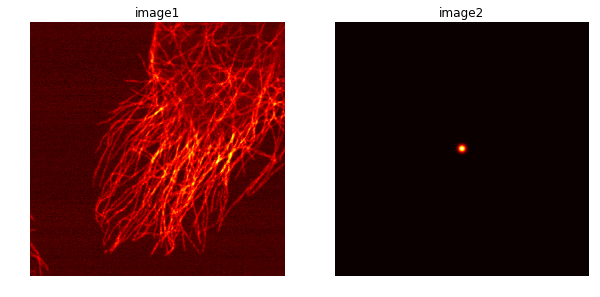

In [10]:
showim.display_2d_images(image, psf)


Run deconvolution

In [11]:
from supertomo.ui import deconvolution_options as options
n_iterations = 40
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=half-bit").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

In [12]:
from scipy.ndimage import gaussian_filter

#psf = Image(gaussian_filter(psf), psf.spacing)
temp_data_dir = os.path.join(data_dir, "theoretical")
if not os.path.exists(temp_data_dir):
    os.mkdir(temp_data_dir)
    
writer = imwrap.TiffImageWriter(temp_data_dir)

task = deconvolve.DeconvolutionRL(image, psf, writer, args)
task.execute()

The original image size is (512, 512)
The deconvolution will be run with 1 blocks
The internal block size is (512, 512)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/40                ] E/S/U/N=0/21205586/14132859/0, LEAK=-0.706315669649%, TAU1=0.0512556992471, TIME=0.108s, U/ESU=0.400 
Beginning the computation of the 1. estimate
[=>                2/40                ] ETA:3.7s E/S/U/N=0/26892332/8473947/0, LEAK=-0.785636573402%, TAU1=0.0344233028591, TIME=8.98E-2s, U/ESU=0.240 
Beginning the computation of the 2. estimate
[==>               3/40                ] ETA:3.4s E/S/U/N=361/29932279/5426690/0, LEAK=-0.765833845599%, TAU1=0.027366137132, TIME=7.95E-2s, U/ESU=0.153 
Beginning the computation of the 3. estimate
[===>             4/40                 ] ETA:3.2s E/S/U/N=0/31479824/3868205/0, LEAK=-0.733626731442%, TAU1=0.0233399868011, TIME=8.28E-2s, U/ESU=0.109 
Beginning the computation of the 4. estimate
[====>            5/40      

[================40/40=================] ETA:0 The number of iterations reached to maximal count: 40 


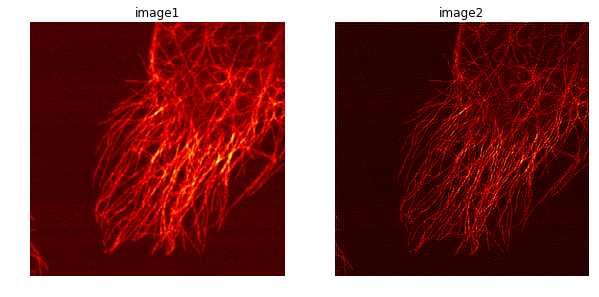

In [13]:
result = task.get_8bit_result()

showim.display_2d_images(image, result)



Show resolution curve

In [14]:
import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt

frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations):
    image_name = "result_{}.tif".format(idx)

    image_path = os.path.join(temp_data_dir, image_name)

    image = read.get_image(image_path)
    image1, image2 = imops.checkerboard_split(image)
    
    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0]*sqrt(2), args)
results = analyzer.execute()


/Users/sami/Programming/GIT/supertomo2/supertomo/analysis/resolution/fourier_ring_correlation.py:78: RuntimeWarning: invalid value encountered in divide
  frc = np.abs(c1) / np.sqrt(c2 * c3)


Fit starts at 0.8984375
Optimization terminated successfully.
         Current function value: 0.000059
         Iterations: 13
         Function evaluations: 27
Fit starts at 0.8984375
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 13
         Function evaluations: 27
Fit starts at 0.8984375
Optimization terminated successfully.
         Current function value: 0.000125
         Iterations: 11
         Function evaluations: 23
Fit starts at 0.8984375
Optimization terminated successfully.
         Current function value: 0.000034
         Iterations: 12
         Function evaluations: 25
Fit starts at 0.8984375
Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 12
         Function evaluations: 25
Fit starts at 0.8984375
Optimization terminated successfully.
         Current function value: 0.000066
         Iterations: 13
         Function evaluations: 27
Fit starts at 0.8984375
Opti

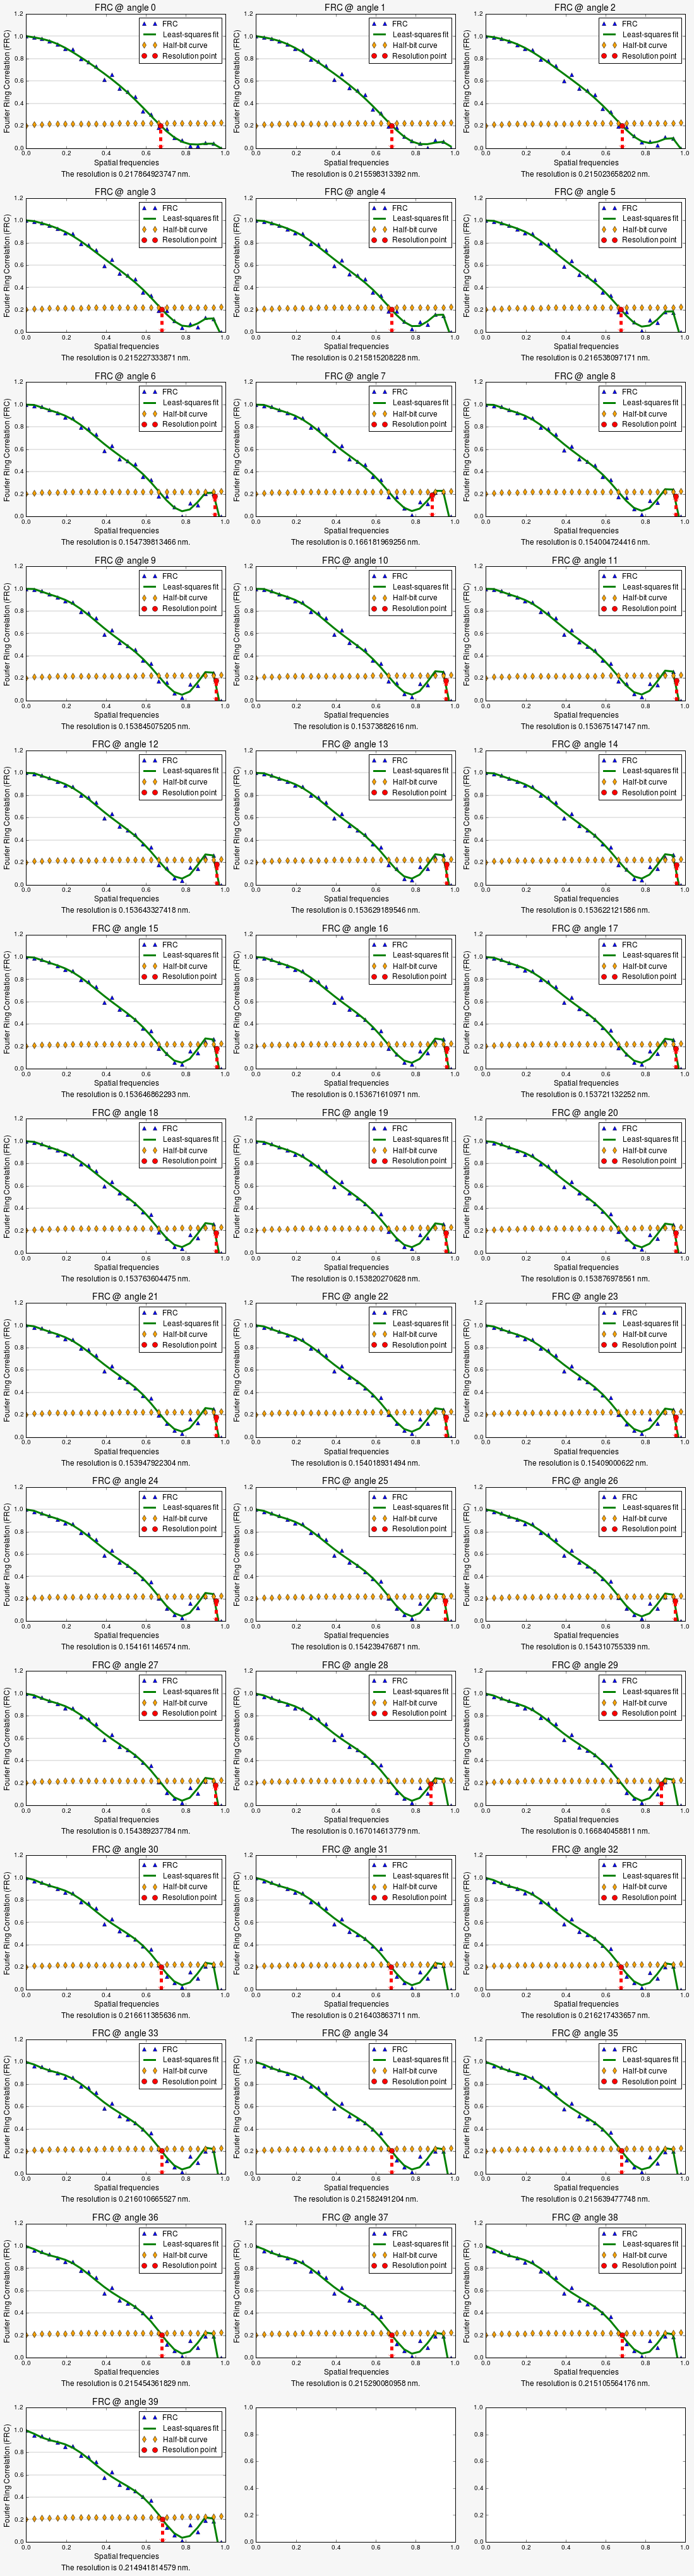

In [15]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

## Regarding the measured FRC values

I wanted to see look more closely into how the FRC values behave as a function of the iteration count. The *SuperTomo* deconvolution algorithm also calculates several parameter values that have traditionally been used to evaluate the progress of an iterative deconvolution. For more info, look at (Koho et al 2014). 

Here I normalize all the parameter values (0-1) for easy comparison and plotting. The original values are maintained in the *deconvolution_parameters* dataframe.

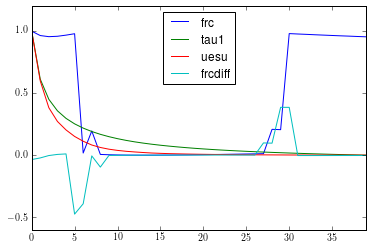

In [16]:
# Get a list of the resolution values as a function of iteration number
iterations = list()
resolutions = list()

for dataset in results:
    iterations.append(int(dataset[0]))
    resolutions.append(dataset[1].resolution["resolution"])

iterations, resolutions = zip(*sorted(zip(iterations, resolutions)))

# Get saved deconvolution parameters
deconvolution_parameters = task.progress_parameters
deconvolution_parameters['frc'] = resolutions


# Set up curves
curves = deconvolution_parameters.loc[:, ['frc', 'tau1', 'uesu']]

curves['frc'] -= curves['frc'].min()
curves['frc'] /= curves['frc'].max()

curves['tau1'] -= curves['tau1'].min()
curves['tau1'] /= curves['tau1'].max()

curves['uesu'] -= curves['uesu'].min()
curves['uesu'] /= curves['uesu'].max() 

curves['frcdiff'] = np.gradient(curves['frc'])



curves.plot()

## Regarding the FRC resolution curve

The FRC resolution value curve behaves in a very interestin way. It is first of all much more linear than *u_esu* and *tau1* and what is quite extraordinary,  the FRC value is able to discern the iteration after which the RL algorithm stops fitting the data, and mainly starts amplifying the noise.

In [17]:
zero_crossing = np.where(np.diff(np.sign(curves['frcdiff'])))[0][0]

print "The deconvolution should be stopped at iteration {}.".format(zero_crossing)

The deconvolution should be stopped at iteration 2.


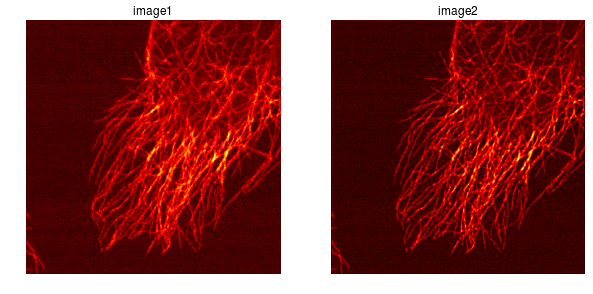

In [18]:
image_path = os.path.join(data_dir, "result_{}.tif".format(zero_crossing))

result_image = read.get_image(image_path)
result_image *= 255/result_image.max()

showim.display_2d_images(image_copy, result_image)


